# HAR LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test) 

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [6]:
# Imports
import tensorflow as tf

lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

/Users/isabelmetzger/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Construct the graph
Placeholders

In [7]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [8]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [9]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train the network

In [10]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [11]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.793282 Train acc: 0.173333
Epoch: 1/1000 Iteration: 10 Train loss: 1.772159 Train acc: 0.221667
Epoch: 1/1000 Iteration: 15 Train loss: 1.778184 Train acc: 0.215000
Epoch: 2/1000 Iteration: 20 Train loss: 1.761023 Train acc: 0.236667
Epoch: 2/1000 Iteration: 25 Train loss: 1.762602 Train acc: 0.223333
Epoch: 2/1000 Iteration: 25 Validation loss: 1.741234 Validation acc: 0.260000
Epoch: 3/1000 Iteration: 30 Train loss: 1.765716 Train acc: 0.240000
Epoch: 3/1000 Iteration: 35 Train loss: 1.736216 Train acc: 0.290000
Epoch: 4/1000 Iteration: 40 Train loss: 1.720584 Train acc: 0.288333
Epoch: 4/1000 Iteration: 45 Train loss: 1.733383 Train acc: 0.303333
Epoch: 5/1000 Iteration: 50 Train loss: 1.728660 Train acc: 0.290000
Epoch: 5/1000 Iteration: 50 Validation loss: 1.701089 Validation acc: 0.290000
Epoch: 6/1000 Iteration: 55 Train loss: 1.712034 Train acc: 0.303333
Epoch: 6/1000 Iteration: 60 Train loss: 1.711733 Train acc: 0.301667
Epoch: 7/1000 I

Epoch: 53/1000 Iteration: 480 Train loss: 0.874268 Train acc: 0.758333
Epoch: 53/1000 Iteration: 485 Train loss: 0.828352 Train acc: 0.788333
Epoch: 54/1000 Iteration: 490 Train loss: 0.870004 Train acc: 0.731667
Epoch: 54/1000 Iteration: 495 Train loss: 0.838335 Train acc: 0.775000
Epoch: 55/1000 Iteration: 500 Train loss: 0.818553 Train acc: 0.780000
Epoch: 55/1000 Iteration: 500 Validation loss: 0.706990 Validation acc: 0.815556
Epoch: 56/1000 Iteration: 505 Train loss: 0.804432 Train acc: 0.796667
Epoch: 56/1000 Iteration: 510 Train loss: 0.819377 Train acc: 0.775000
Epoch: 57/1000 Iteration: 515 Train loss: 0.784235 Train acc: 0.780000
Epoch: 57/1000 Iteration: 520 Train loss: 0.779013 Train acc: 0.783333
Epoch: 58/1000 Iteration: 525 Train loss: 0.805656 Train acc: 0.775000
Epoch: 58/1000 Iteration: 525 Validation loss: 0.671902 Validation acc: 0.817222
Epoch: 58/1000 Iteration: 530 Train loss: 0.788271 Train acc: 0.793333
Epoch: 59/1000 Iteration: 535 Train loss: 0.803916 Train 

Epoch: 105/1000 Iteration: 950 Validation loss: 0.376535 Validation acc: 0.892778
Epoch: 106/1000 Iteration: 955 Train loss: 0.463073 Train acc: 0.870000
Epoch: 106/1000 Iteration: 960 Train loss: 0.482518 Train acc: 0.865000
Epoch: 107/1000 Iteration: 965 Train loss: 0.480941 Train acc: 0.886667
Epoch: 107/1000 Iteration: 970 Train loss: 0.468545 Train acc: 0.876667
Epoch: 108/1000 Iteration: 975 Train loss: 0.492459 Train acc: 0.873333
Epoch: 108/1000 Iteration: 975 Validation loss: 0.361038 Validation acc: 0.898889
Epoch: 108/1000 Iteration: 980 Train loss: 0.456660 Train acc: 0.888333
Epoch: 109/1000 Iteration: 985 Train loss: 0.499478 Train acc: 0.861667
Epoch: 109/1000 Iteration: 990 Train loss: 0.487196 Train acc: 0.866667
Epoch: 110/1000 Iteration: 995 Train loss: 0.432714 Train acc: 0.891667
Epoch: 111/1000 Iteration: 1000 Train loss: 0.468375 Train acc: 0.881667
Epoch: 111/1000 Iteration: 1000 Validation loss: 0.345558 Validation acc: 0.905556
Epoch: 111/1000 Iteration: 1005 

Epoch: 156/1000 Iteration: 1410 Train loss: 0.277852 Train acc: 0.950000
Epoch: 157/1000 Iteration: 1415 Train loss: 0.261989 Train acc: 0.956667
Epoch: 157/1000 Iteration: 1420 Train loss: 0.276178 Train acc: 0.945000
Epoch: 158/1000 Iteration: 1425 Train loss: 0.295229 Train acc: 0.938333
Epoch: 158/1000 Iteration: 1425 Validation loss: 0.184553 Validation acc: 0.952778
Epoch: 158/1000 Iteration: 1430 Train loss: 0.265254 Train acc: 0.955000
Epoch: 159/1000 Iteration: 1435 Train loss: 0.312231 Train acc: 0.918333
Epoch: 159/1000 Iteration: 1440 Train loss: 0.305458 Train acc: 0.936667
Epoch: 160/1000 Iteration: 1445 Train loss: 0.255783 Train acc: 0.950000
Epoch: 161/1000 Iteration: 1450 Train loss: 0.267526 Train acc: 0.945000
Epoch: 161/1000 Iteration: 1450 Validation loss: 0.184417 Validation acc: 0.951111
Epoch: 161/1000 Iteration: 1455 Train loss: 0.262729 Train acc: 0.948333
Epoch: 162/1000 Iteration: 1460 Train loss: 0.234693 Train acc: 0.965000
Epoch: 162/1000 Iteration: 1465

Epoch: 207/1000 Iteration: 1870 Train loss: 0.207100 Train acc: 0.946667
Epoch: 208/1000 Iteration: 1875 Train loss: 0.228689 Train acc: 0.945000
Epoch: 208/1000 Iteration: 1875 Validation loss: 0.154481 Validation acc: 0.952222
Epoch: 208/1000 Iteration: 1880 Train loss: 0.188325 Train acc: 0.958333
Epoch: 209/1000 Iteration: 1885 Train loss: 0.242297 Train acc: 0.938333
Epoch: 209/1000 Iteration: 1890 Train loss: 0.242853 Train acc: 0.948333
Epoch: 210/1000 Iteration: 1895 Train loss: 0.200484 Train acc: 0.960000
Epoch: 211/1000 Iteration: 1900 Train loss: 0.209259 Train acc: 0.956667
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.153371 Validation acc: 0.951111
Epoch: 211/1000 Iteration: 1905 Train loss: 0.198413 Train acc: 0.958333
Epoch: 212/1000 Iteration: 1910 Train loss: 0.210757 Train acc: 0.951667
Epoch: 212/1000 Iteration: 1915 Train loss: 0.212452 Train acc: 0.953333
Epoch: 213/1000 Iteration: 1920 Train loss: 0.208559 Train acc: 0.951667
Epoch: 213/1000 Iteration: 1925

Epoch: 258/1000 Iteration: 2325 Validation loss: 0.139372 Validation acc: 0.951667
Epoch: 258/1000 Iteration: 2330 Train loss: 0.162819 Train acc: 0.973333
Epoch: 259/1000 Iteration: 2335 Train loss: 0.210957 Train acc: 0.933333
Epoch: 259/1000 Iteration: 2340 Train loss: 0.218107 Train acc: 0.946667
Epoch: 260/1000 Iteration: 2345 Train loss: 0.183274 Train acc: 0.950000
Epoch: 261/1000 Iteration: 2350 Train loss: 0.183076 Train acc: 0.956667
Epoch: 261/1000 Iteration: 2350 Validation loss: 0.143853 Validation acc: 0.948889
Epoch: 261/1000 Iteration: 2355 Train loss: 0.163885 Train acc: 0.960000
Epoch: 262/1000 Iteration: 2360 Train loss: 0.181485 Train acc: 0.958333
Epoch: 262/1000 Iteration: 2365 Train loss: 0.180163 Train acc: 0.953333
Epoch: 263/1000 Iteration: 2370 Train loss: 0.210441 Train acc: 0.950000
Epoch: 263/1000 Iteration: 2375 Train loss: 0.165412 Train acc: 0.965000
Epoch: 263/1000 Iteration: 2375 Validation loss: 0.140862 Validation acc: 0.950556
Epoch: 264/1000 Itera

Epoch: 309/1000 Iteration: 2785 Train loss: 0.187584 Train acc: 0.940000
Epoch: 309/1000 Iteration: 2790 Train loss: 0.190060 Train acc: 0.953333
Epoch: 310/1000 Iteration: 2795 Train loss: 0.148726 Train acc: 0.955000
Epoch: 311/1000 Iteration: 2800 Train loss: 0.160846 Train acc: 0.961667
Epoch: 311/1000 Iteration: 2800 Validation loss: 0.131958 Validation acc: 0.951111
Epoch: 311/1000 Iteration: 2805 Train loss: 0.148898 Train acc: 0.966667
Epoch: 312/1000 Iteration: 2810 Train loss: 0.172976 Train acc: 0.955000
Epoch: 312/1000 Iteration: 2815 Train loss: 0.182335 Train acc: 0.961667
Epoch: 313/1000 Iteration: 2820 Train loss: 0.191726 Train acc: 0.943333
Epoch: 313/1000 Iteration: 2825 Train loss: 0.153873 Train acc: 0.966667
Epoch: 313/1000 Iteration: 2825 Validation loss: 0.132470 Validation acc: 0.948889
Epoch: 314/1000 Iteration: 2830 Train loss: 0.201617 Train acc: 0.941667
Epoch: 314/1000 Iteration: 2835 Train loss: 0.211583 Train acc: 0.945000
Epoch: 315/1000 Iteration: 2840

Epoch: 360/1000 Iteration: 3245 Train loss: 0.146271 Train acc: 0.968333
Epoch: 361/1000 Iteration: 3250 Train loss: 0.145024 Train acc: 0.960000
Epoch: 361/1000 Iteration: 3250 Validation loss: 0.128978 Validation acc: 0.950556
Epoch: 361/1000 Iteration: 3255 Train loss: 0.132437 Train acc: 0.971667
Epoch: 362/1000 Iteration: 3260 Train loss: 0.169083 Train acc: 0.956667
Epoch: 362/1000 Iteration: 3265 Train loss: 0.161844 Train acc: 0.961667
Epoch: 363/1000 Iteration: 3270 Train loss: 0.172644 Train acc: 0.950000
Epoch: 363/1000 Iteration: 3275 Train loss: 0.131751 Train acc: 0.968333
Epoch: 363/1000 Iteration: 3275 Validation loss: 0.124756 Validation acc: 0.955555
Epoch: 364/1000 Iteration: 3280 Train loss: 0.178379 Train acc: 0.930000
Epoch: 364/1000 Iteration: 3285 Train loss: 0.168176 Train acc: 0.950000
Epoch: 365/1000 Iteration: 3290 Train loss: 0.152822 Train acc: 0.956667
Epoch: 366/1000 Iteration: 3295 Train loss: 0.151499 Train acc: 0.956667
Epoch: 366/1000 Iteration: 3300

Epoch: 411/1000 Iteration: 3700 Validation loss: 0.125365 Validation acc: 0.957222
Epoch: 411/1000 Iteration: 3705 Train loss: 0.129734 Train acc: 0.956667
Epoch: 412/1000 Iteration: 3710 Train loss: 0.154950 Train acc: 0.955000
Epoch: 412/1000 Iteration: 3715 Train loss: 0.135172 Train acc: 0.963333
Epoch: 413/1000 Iteration: 3720 Train loss: 0.156054 Train acc: 0.953333
Epoch: 413/1000 Iteration: 3725 Train loss: 0.110364 Train acc: 0.971667
Epoch: 413/1000 Iteration: 3725 Validation loss: 0.124261 Validation acc: 0.956111
Epoch: 414/1000 Iteration: 3730 Train loss: 0.176249 Train acc: 0.941667
Epoch: 414/1000 Iteration: 3735 Train loss: 0.172130 Train acc: 0.948333
Epoch: 415/1000 Iteration: 3740 Train loss: 0.132979 Train acc: 0.963333
Epoch: 416/1000 Iteration: 3745 Train loss: 0.132662 Train acc: 0.965000
Epoch: 416/1000 Iteration: 3750 Train loss: 0.127989 Train acc: 0.963333
Epoch: 416/1000 Iteration: 3750 Validation loss: 0.125147 Validation acc: 0.953889
Epoch: 417/1000 Itera

Epoch: 462/1000 Iteration: 4160 Train loss: 0.129469 Train acc: 0.960000
Epoch: 462/1000 Iteration: 4165 Train loss: 0.126842 Train acc: 0.966667
Epoch: 463/1000 Iteration: 4170 Train loss: 0.157385 Train acc: 0.960000
Epoch: 463/1000 Iteration: 4175 Train loss: 0.105448 Train acc: 0.971667
Epoch: 463/1000 Iteration: 4175 Validation loss: 0.119396 Validation acc: 0.957222
Epoch: 464/1000 Iteration: 4180 Train loss: 0.173189 Train acc: 0.943333
Epoch: 464/1000 Iteration: 4185 Train loss: 0.155882 Train acc: 0.956667
Epoch: 465/1000 Iteration: 4190 Train loss: 0.132472 Train acc: 0.963333
Epoch: 466/1000 Iteration: 4195 Train loss: 0.117101 Train acc: 0.968333
Epoch: 466/1000 Iteration: 4200 Train loss: 0.128431 Train acc: 0.960000
Epoch: 466/1000 Iteration: 4200 Validation loss: 0.123999 Validation acc: 0.955000
Epoch: 467/1000 Iteration: 4205 Train loss: 0.144947 Train acc: 0.961667
Epoch: 467/1000 Iteration: 4210 Train loss: 0.133684 Train acc: 0.968333
Epoch: 468/1000 Iteration: 4215

Epoch: 513/1000 Iteration: 4620 Train loss: 0.152661 Train acc: 0.955000
Epoch: 513/1000 Iteration: 4625 Train loss: 0.101324 Train acc: 0.980000
Epoch: 513/1000 Iteration: 4625 Validation loss: 0.119844 Validation acc: 0.954444
Epoch: 514/1000 Iteration: 4630 Train loss: 0.172872 Train acc: 0.945000
Epoch: 514/1000 Iteration: 4635 Train loss: 0.147905 Train acc: 0.950000
Epoch: 515/1000 Iteration: 4640 Train loss: 0.114519 Train acc: 0.961667
Epoch: 516/1000 Iteration: 4645 Train loss: 0.105888 Train acc: 0.968333
Epoch: 516/1000 Iteration: 4650 Train loss: 0.102445 Train acc: 0.975000
Epoch: 516/1000 Iteration: 4650 Validation loss: 0.120686 Validation acc: 0.953889
Epoch: 517/1000 Iteration: 4655 Train loss: 0.131673 Train acc: 0.963333
Epoch: 517/1000 Iteration: 4660 Train loss: 0.117963 Train acc: 0.971667
Epoch: 518/1000 Iteration: 4665 Train loss: 0.140705 Train acc: 0.956667
Epoch: 518/1000 Iteration: 4670 Train loss: 0.090824 Train acc: 0.976667
Epoch: 519/1000 Iteration: 4675

Epoch: 563/1000 Iteration: 5075 Validation loss: 0.120463 Validation acc: 0.953889
Epoch: 564/1000 Iteration: 5080 Train loss: 0.145397 Train acc: 0.948333
Epoch: 564/1000 Iteration: 5085 Train loss: 0.155289 Train acc: 0.958333
Epoch: 565/1000 Iteration: 5090 Train loss: 0.121748 Train acc: 0.966667
Epoch: 566/1000 Iteration: 5095 Train loss: 0.111447 Train acc: 0.965000
Epoch: 566/1000 Iteration: 5100 Train loss: 0.098995 Train acc: 0.973333
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.118321 Validation acc: 0.954444
Epoch: 567/1000 Iteration: 5105 Train loss: 0.119718 Train acc: 0.965000
Epoch: 567/1000 Iteration: 5110 Train loss: 0.128840 Train acc: 0.970000
Epoch: 568/1000 Iteration: 5115 Train loss: 0.144640 Train acc: 0.948333
Epoch: 568/1000 Iteration: 5120 Train loss: 0.085862 Train acc: 0.981667
Epoch: 569/1000 Iteration: 5125 Train loss: 0.142336 Train acc: 0.953333
Epoch: 569/1000 Iteration: 5125 Validation loss: 0.117118 Validation acc: 0.955000
Epoch: 569/1000 Itera

Epoch: 614/1000 Iteration: 5535 Train loss: 0.138629 Train acc: 0.956667
Epoch: 615/1000 Iteration: 5540 Train loss: 0.101940 Train acc: 0.966667
Epoch: 616/1000 Iteration: 5545 Train loss: 0.101144 Train acc: 0.976667
Epoch: 616/1000 Iteration: 5550 Train loss: 0.097091 Train acc: 0.968333
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.113796 Validation acc: 0.955000
Epoch: 617/1000 Iteration: 5555 Train loss: 0.122282 Train acc: 0.965000
Epoch: 617/1000 Iteration: 5560 Train loss: 0.095401 Train acc: 0.975000
Epoch: 618/1000 Iteration: 5565 Train loss: 0.125808 Train acc: 0.958333
Epoch: 618/1000 Iteration: 5570 Train loss: 0.081405 Train acc: 0.981667
Epoch: 619/1000 Iteration: 5575 Train loss: 0.148035 Train acc: 0.941667
Epoch: 619/1000 Iteration: 5575 Validation loss: 0.115192 Validation acc: 0.953333
Epoch: 619/1000 Iteration: 5580 Train loss: 0.141208 Train acc: 0.953333
Epoch: 620/1000 Iteration: 5585 Train loss: 0.111975 Train acc: 0.960000
Epoch: 621/1000 Iteration: 5590

Epoch: 666/1000 Iteration: 5995 Train loss: 0.089909 Train acc: 0.973333
Epoch: 666/1000 Iteration: 6000 Train loss: 0.082210 Train acc: 0.981667
Epoch: 666/1000 Iteration: 6000 Validation loss: 0.109692 Validation acc: 0.956111
Epoch: 667/1000 Iteration: 6005 Train loss: 0.108754 Train acc: 0.968333
Epoch: 667/1000 Iteration: 6010 Train loss: 0.091305 Train acc: 0.973333
Epoch: 668/1000 Iteration: 6015 Train loss: 0.121819 Train acc: 0.961667
Epoch: 668/1000 Iteration: 6020 Train loss: 0.081393 Train acc: 0.978333
Epoch: 669/1000 Iteration: 6025 Train loss: 0.129230 Train acc: 0.951667
Epoch: 669/1000 Iteration: 6025 Validation loss: 0.108212 Validation acc: 0.955000
Epoch: 669/1000 Iteration: 6030 Train loss: 0.135290 Train acc: 0.955000
Epoch: 670/1000 Iteration: 6035 Train loss: 0.109169 Train acc: 0.970000
Epoch: 671/1000 Iteration: 6040 Train loss: 0.094246 Train acc: 0.975000
Epoch: 671/1000 Iteration: 6045 Train loss: 0.096510 Train acc: 0.971667
Epoch: 672/1000 Iteration: 6050

Epoch: 716/1000 Iteration: 6450 Validation loss: 0.104102 Validation acc: 0.958889
Epoch: 717/1000 Iteration: 6455 Train loss: 0.101730 Train acc: 0.965000
Epoch: 717/1000 Iteration: 6460 Train loss: 0.103438 Train acc: 0.971667
Epoch: 718/1000 Iteration: 6465 Train loss: 0.112337 Train acc: 0.966667
Epoch: 718/1000 Iteration: 6470 Train loss: 0.071674 Train acc: 0.980000
Epoch: 719/1000 Iteration: 6475 Train loss: 0.126945 Train acc: 0.950000
Epoch: 719/1000 Iteration: 6475 Validation loss: 0.105557 Validation acc: 0.957778
Epoch: 719/1000 Iteration: 6480 Train loss: 0.130398 Train acc: 0.958333
Epoch: 720/1000 Iteration: 6485 Train loss: 0.107040 Train acc: 0.963333
Epoch: 721/1000 Iteration: 6490 Train loss: 0.085985 Train acc: 0.975000
Epoch: 721/1000 Iteration: 6495 Train loss: 0.087066 Train acc: 0.968333
Epoch: 722/1000 Iteration: 6500 Train loss: 0.105016 Train acc: 0.966667
Epoch: 722/1000 Iteration: 6500 Validation loss: 0.104488 Validation acc: 0.959444
Epoch: 722/1000 Itera

Epoch: 767/1000 Iteration: 6910 Train loss: 0.084484 Train acc: 0.978333
Epoch: 768/1000 Iteration: 6915 Train loss: 0.114851 Train acc: 0.955000
Epoch: 768/1000 Iteration: 6920 Train loss: 0.068740 Train acc: 0.980000
Epoch: 769/1000 Iteration: 6925 Train loss: 0.120860 Train acc: 0.956667
Epoch: 769/1000 Iteration: 6925 Validation loss: 0.102519 Validation acc: 0.962222
Epoch: 769/1000 Iteration: 6930 Train loss: 0.126386 Train acc: 0.955000
Epoch: 770/1000 Iteration: 6935 Train loss: 0.096100 Train acc: 0.975000
Epoch: 771/1000 Iteration: 6940 Train loss: 0.087400 Train acc: 0.978333
Epoch: 771/1000 Iteration: 6945 Train loss: 0.086781 Train acc: 0.973333
Epoch: 772/1000 Iteration: 6950 Train loss: 0.107293 Train acc: 0.971667
Epoch: 772/1000 Iteration: 6950 Validation loss: 0.107006 Validation acc: 0.961667
Epoch: 772/1000 Iteration: 6955 Train loss: 0.087208 Train acc: 0.976667
Epoch: 773/1000 Iteration: 6960 Train loss: 0.102171 Train acc: 0.968333
Epoch: 773/1000 Iteration: 6965

Epoch: 818/1000 Iteration: 7370 Train loss: 0.063880 Train acc: 0.986667
Epoch: 819/1000 Iteration: 7375 Train loss: 0.131733 Train acc: 0.946667
Epoch: 819/1000 Iteration: 7375 Validation loss: 0.108976 Validation acc: 0.964444
Epoch: 819/1000 Iteration: 7380 Train loss: 0.125632 Train acc: 0.960000
Epoch: 820/1000 Iteration: 7385 Train loss: 0.077381 Train acc: 0.971667
Epoch: 821/1000 Iteration: 7390 Train loss: 0.081760 Train acc: 0.971667
Epoch: 821/1000 Iteration: 7395 Train loss: 0.089411 Train acc: 0.966667
Epoch: 822/1000 Iteration: 7400 Train loss: 0.104208 Train acc: 0.966667
Epoch: 822/1000 Iteration: 7400 Validation loss: 0.110158 Validation acc: 0.962222
Epoch: 822/1000 Iteration: 7405 Train loss: 0.094588 Train acc: 0.966667
Epoch: 823/1000 Iteration: 7410 Train loss: 0.106605 Train acc: 0.963333
Epoch: 823/1000 Iteration: 7415 Train loss: 0.059698 Train acc: 0.986667
Epoch: 824/1000 Iteration: 7420 Train loss: 0.140708 Train acc: 0.956667
Epoch: 824/1000 Iteration: 7425

Epoch: 869/1000 Iteration: 7825 Validation loss: 0.108978 Validation acc: 0.964444
Epoch: 869/1000 Iteration: 7830 Train loss: 0.112708 Train acc: 0.958333
Epoch: 870/1000 Iteration: 7835 Train loss: 0.087019 Train acc: 0.970000
Epoch: 871/1000 Iteration: 7840 Train loss: 0.097496 Train acc: 0.970000
Epoch: 871/1000 Iteration: 7845 Train loss: 0.073678 Train acc: 0.980000
Epoch: 872/1000 Iteration: 7850 Train loss: 0.091182 Train acc: 0.971667
Epoch: 872/1000 Iteration: 7850 Validation loss: 0.103360 Validation acc: 0.965000
Epoch: 872/1000 Iteration: 7855 Train loss: 0.091989 Train acc: 0.973333
Epoch: 873/1000 Iteration: 7860 Train loss: 0.115334 Train acc: 0.960000
Epoch: 873/1000 Iteration: 7865 Train loss: 0.071099 Train acc: 0.981667
Epoch: 874/1000 Iteration: 7870 Train loss: 0.121296 Train acc: 0.956667
Epoch: 874/1000 Iteration: 7875 Train loss: 0.116656 Train acc: 0.955000
Epoch: 874/1000 Iteration: 7875 Validation loss: 0.107896 Validation acc: 0.962778
Epoch: 875/1000 Itera

Epoch: 920/1000 Iteration: 8285 Train loss: 0.082800 Train acc: 0.980000
Epoch: 921/1000 Iteration: 8290 Train loss: 0.073478 Train acc: 0.978333
Epoch: 921/1000 Iteration: 8295 Train loss: 0.073688 Train acc: 0.978333
Epoch: 922/1000 Iteration: 8300 Train loss: 0.091629 Train acc: 0.970000
Epoch: 922/1000 Iteration: 8300 Validation loss: 0.107211 Validation acc: 0.963889
Epoch: 922/1000 Iteration: 8305 Train loss: 0.073433 Train acc: 0.976667
Epoch: 923/1000 Iteration: 8310 Train loss: 0.097501 Train acc: 0.965000
Epoch: 923/1000 Iteration: 8315 Train loss: 0.058718 Train acc: 0.985000
Epoch: 924/1000 Iteration: 8320 Train loss: 0.113035 Train acc: 0.956667
Epoch: 924/1000 Iteration: 8325 Train loss: 0.120725 Train acc: 0.960000
Epoch: 924/1000 Iteration: 8325 Validation loss: 0.107090 Validation acc: 0.964444
Epoch: 925/1000 Iteration: 8330 Train loss: 0.085026 Train acc: 0.973333
Epoch: 926/1000 Iteration: 8335 Train loss: 0.081749 Train acc: 0.971667
Epoch: 926/1000 Iteration: 8340

Epoch: 971/1000 Iteration: 8745 Train loss: 0.067577 Train acc: 0.975000
Epoch: 972/1000 Iteration: 8750 Train loss: 0.079873 Train acc: 0.975000
Epoch: 972/1000 Iteration: 8750 Validation loss: 0.107406 Validation acc: 0.962778
Epoch: 972/1000 Iteration: 8755 Train loss: 0.088051 Train acc: 0.966667
Epoch: 973/1000 Iteration: 8760 Train loss: 0.101068 Train acc: 0.966667
Epoch: 973/1000 Iteration: 8765 Train loss: 0.057422 Train acc: 0.988333
Epoch: 974/1000 Iteration: 8770 Train loss: 0.116406 Train acc: 0.956667
Epoch: 974/1000 Iteration: 8775 Train loss: 0.108281 Train acc: 0.958333
Epoch: 974/1000 Iteration: 8775 Validation loss: 0.106816 Validation acc: 0.962778
Epoch: 975/1000 Iteration: 8780 Train loss: 0.082707 Train acc: 0.976667
Epoch: 976/1000 Iteration: 8785 Train loss: 0.076465 Train acc: 0.980000
Epoch: 976/1000 Iteration: 8790 Train loss: 0.071154 Train acc: 0.980000
Epoch: 977/1000 Iteration: 8795 Train loss: 0.073746 Train acc: 0.971667
Epoch: 977/1000 Iteration: 8800

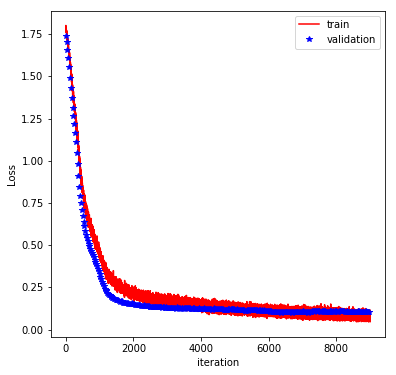

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

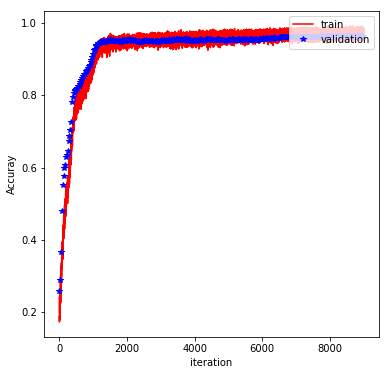

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    # INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
#Test accuracy: 0.878333

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Test accuracy: 0.878333
